<a href="https://colab.research.google.com/github/003084-K/cardsort/blob/Preprocessing/Data_Pre_Processing_MO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

%matplotlib inline 

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

## Data Generation

Convention for mock data:

Row 1 = shape  
Row 2 = number  
Row 3 = color

In [0]:
# Make 1-hot encoded numpy array for each card
card_list = np.zeros((64,3,4))

In [68]:
card_list.shape

(64, 3, 4)

In [0]:
for i, (shape, number, color) in enumerate(itertools.product(range(0,4), range(0,4), range(0,4))):
    card_list[i][0][shape] = 1
    card_list[i][1][number] = 1
    card_list[i][2][color] = 1

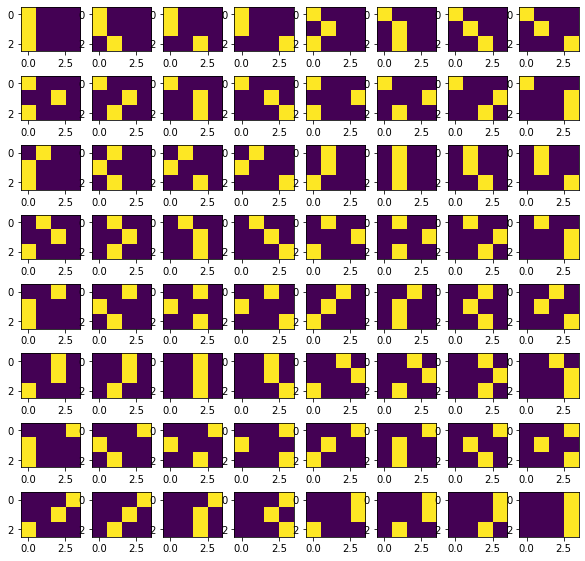

In [70]:
f, ax = plt.subplots(nrows=8, ncols=8, figsize=[10,10])
for i in range(0, card_list.shape[0]):
    ax.flatten()[i].imshow(card_list[i])
# plt.tight_layout()
plt.show() 

In [0]:
# goal: be able to randomly sample from all possible sets of cards as quickly as possible
# solution: pre-determine all possible combinations of cards given each test card and store for future stochastic sampling
# we can randomly shuffle the order of cards in a given set when generating batches

In [0]:
sets = []

# for each probe card, determine all possible sets
for p_card in card_list:
  # first determine all cards matching in shape (but not other features)
  for s_card in card_list:
    if (np.sum((s_card==p_card),axis=1)==(4,2,2)).all():
      # for each card that matches in number (but not other features) that doesn't share features with shapecard
      for n_card in card_list:
        if (np.sum((n_card==p_card),axis=1)==(2,4,2)).all() and (np.sum((n_card==s_card),axis=1)==(2,2,2)).all():
          # for each card that matches in color (but not other features) that doesn't share features with shapecard or numcard
          for c_card in card_list:
            if (np.sum((c_card==p_card),axis=1)==(2,2,4)).all() and (np.sum((c_card==s_card),axis=1)==(2,2,2)).all() and (np.sum((c_card==n_card),axis=1)==(2,2,2)).all():
            # for each card that matches in no features that doesn't share features with shapecard or numcard or colorcard
              for no_card in card_list:
                if (np.sum((no_card==p_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==s_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==n_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==c_card),axis=1)==(2,2,2)).all():
                # save whole set
                  sets.append((s_card,n_card,c_card,no_card,p_card))

sets = np.array(sets)

In [73]:
sets.shape

(13824, 5, 3, 4)

In [0]:
#print(sets[0:9])
#print(sets[0:9,:,:,:])


# Preprocessing


1.   Split data: train/validation/testing
2.   Create rule & labels
3.   Create a DataLoader

### Split Data

In [0]:
#Proportions of dataset to allocate to training, validation, testing
TRAIN_PERC = 0.90
VALID_PERC = 0.05
TEST_PERC = 1 - TRAIN_PERC - VALID_PERC

In [0]:
# Allocate proportions of dataset: 90% training, 5% validation, 5% testing
train_indx_start = 0 
valid_indx_start = round(sets.shape[0]*TRAIN_PERC)
test_indx_start  = valid_indx_start + round(sets.shape[0]*VALID_PERC)
test_indx_end = len(sets)

In [0]:
sets_train = sets[train_indx_start:(valid_indx_start)]
sets_valid = sets[valid_indx_start:(test_indx_start)]
sets_test = sets[test_indx_start:len(sets)]

In [253]:
print('Training size: ', sets_train.shape[0])
print('Validation size: ', sets_valid.shape[0])
print('Test size: ', sets_test.shape[0])

Training size:  12442
Validation size:  691
Test size:  691


### Create labels

In [0]:
#Set the row/feature to match reference-probe
MATCH_FEATURE = 0

In [0]:
#Create manual labels
train_label_man = np.zeros((4,1)) #instantiate
train_label_man[MATCH_FEATURE] = 1

In [0]:
#Generate label from each reference-probe set
train_reference = sets_train[:,0:4,:,:]
train_probe = sets_train[:,-1,:,:]

train_label = np.zeros((len(train_probe),4,1))

#Sanity Check: 
# 1. each set contains a match
# 2. each match is expected card

## Note - Could make function to output labels for train, valid & test sets
QC = 'pass'
for i in range(train_probe.shape[0]):
  label = np.zeros((4, 1)) #instantiate one-hot label
  match_exists = False
  match_card = False
  for ii in range(4):
    if sum(train_reference[i][ii][MATCH_FEATURE] == 
           train_probe[i][MATCH_FEATURE]) == 4:
        label[ii] = 1 #one-hot encoding of matched row
        train_label[i] = label #append label vector
        match_exists = True
    #Error if matches not generated as expected
    if (label == train_label_man).all:
        match_card = True
    elif ii == 3 & match_exists == False: 
        print("error, no match for index: ", i)
        QC = 'fail'
    elif ii == 3 & match_card == False:
        print("error, card match is not expected row for index: ", i)
        QC = 'fail'
  if i == train_probe.shape[0]-1:
    print("Matching QC:", QC)

In [0]:
# Add labels to each dataset

# Load necessary Pytorch packages
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)
train_dataset = TensorDataset(Tensor(sets_train), Tensor(train_label))
valid_dataset = TensorDataset(Tensor(sets_valid), Tensor(train_label[0:len(sets_valid)]))
test_dataset = TensorDataset(Tensor(sets_test), Tensor(train_label[0:len(sets_test)]))

###Instantiate Dataloader

In [0]:
BATCH_SIZE = 100
NUM_WORKERS = 4

In [0]:
# Create a data loader from the dataset
# Type of sampling and batch size are specified at this step
train_loader = DataLoader(
    train_dataset,
    batch_size= BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS)

valid_loader = DataLoader(
    valid_dataset,
    batch_size= BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS)

test_loader = DataLoader(
    test_dataset,
    batch_size= BATCH_SIZE,
    shuffle=False,
    num_workers = NUM_WORKERS)

In [261]:
print(train_loader.dataset[1])

(tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]]), tensor([[1.],
        [0.],
        [0.],
        [0.]]))


In [0]:
batch, classes = next(iter(train_loader))

In [263]:
batch.shape

torch.Size([100, 5, 3, 4])

In [264]:
batch.shape, classes.shape

(torch.Size([100, 5, 3, 4]), torch.Size([100, 4, 1]))

Match rule/row:  0
Label: tensor([[1.],
        [0.],
        [0.],
        [0.]])


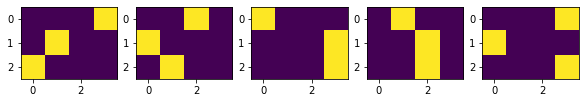

In [265]:
example = 10
print('Match rule/row: ', MATCH_FEATURE) #display matching rule
print('Label:', classes[example]) # display the digit label

#Plot the image
f, ax = plt.subplots(nrows=1, ncols=5, figsize=[10,10])
for i in range(0,np.squeeze(batch)[example].shape[0]):
    ax.flatten()[i].imshow(np.squeeze(batch)[example][i])

plt.show() 


# Architecture

In [0]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()

        # determine encoding for a card
        self.encoding = nn.Sequential(nn.Linear(12, 6), # single card has 12 features
                                nn.ReLU(),  # Do we need this nonlinearity? can't this network be a single layer from 12 to 2?
                                nn.Linear(6, 2))


    def forward(self, x):
        c1_fs = self.encoding(x[0])
        c2_fs = self.encoding(x[1])
        c3_fs = self.encoding(x[2])
        c4_fs = self.encoding(x[3])
        p_fs = self.encoding(x[4])

        dists = (torch.dist(p_fs, c1_fs), torch.dist(p_fs, c2_fs), torch.dist(p_fs, c3_fs), torch.dist(p_fs, c4_fs)) # compare each feature representation to that of probe card

        return F.log_softmax(-dists)    # softmax of negative distance means things closer have larger confidence
        # network should learn to ignore all features except match feature in generating feature representations